# August stim analysis, 2021

**Motivation**: Stim play (stim times) <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import load_allen, make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.svinet import *
from utils.plotting import *
from utils.render import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

## Mice

In [2]:
mode = 'bold'
metric = 'pearson'
match_metric = 'cosine'

task = 'led'
mice = Mice(Config(64, normalization='global'), load_df=True, load_preproc=True)
mice.combine_dfs(task, full=True)

In [3]:
region_overlap = mice.parcel.get_region_overlap()

include = {}
for region, x in region_overlap.items():
    if 'VIS' in x and region <= mice.cfg.n_cortex_regions // 2:
        # print(region, x)
        include[region] = x
include

  0%|          | 0/64 [00:00<?, ?it/s]

{
    24: {'VIS': 55.0, 'PTLp': 45.0},
    28: {'VIS': 87.0},
    30: {'VIS': 63.0, 'RSP': 37.0},
    31: {'VIS': 98.0},
    32: {'VIS': 89.0}
}

In [8]:
delay = 10
extent = 15
dlist = []
ctr = 0
all_baselines = []
for sub in tqdm(range(1, 11)):
    for ses in range(1, 4):
        for run in range(1, 8):
            _df = mice.bold_df
            _df = _df.loc[
                (_df.subject == sub) &
                (_df.session == ses) &
                (_df.run == run)
            ]
            if not _df.stim.sum():
                continue

            # print(sub, ses, run, _df.stim.sum())

            for i in include:
                df_l = _df.loc[_df.region_id == f"0-315-{i}"]
                df_r = _df.loc[_df.region_id == f"1-315-{i + mice.cfg.n_cortex_regions // 2}"]
                stim = df_r.stim.values
                stim_on = [
                    idx + 1 for idx, (i, j)
                    in enumerate(zip(stim[:-1], stim[1:]))
                    if i - j == -1
                ]
                data_dict = {
                    'sub': [sub] * len(stim),
                    'ses': [ses] * len(stim),
                    'run': [run] * len(stim),
                    'stim': stim,
                    't': range(len(stim)),
                }
                dlist.append(data_dict)
data = pd.DataFrame(merge_dicts(dlist))

  0%|          | 0/10 [00:00<?, ?it/s]

<AxesSubplot:xlabel='t', ylabel='stim'>

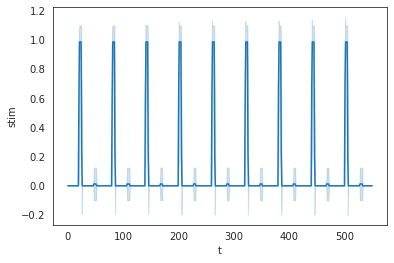

In [10]:
sns.lineplot(data=data, x='t', y='stim', ci='sd')

In [4]:
delay = 10
extent = 15
dlist = []
ctr = 0
all_baselines = []
for sub in tqdm(range(1, 11)):
    for ses in range(1, 4):
        for run in range(1, 8):
            _df = mice.bold_df
            _df = _df.loc[
                (_df.subject == sub) &
                (_df.session == ses) &
                (_df.run == run)
            ]
            if not _df.stim.sum():
                continue

            # print(sub, ses, run, _df.stim.sum())

            for i in include:
                df_l = _df.loc[_df.region_id == f"0-315-{i}"]
                df_r = _df.loc[_df.region_id == f"1-315-{i + mice.cfg.n_cortex_regions // 2}"]
                stim = df_r.stim.values
                stim_on = [
                    idx + 1 for idx, (i, j)
                    in enumerate(zip(stim[:-1], stim[1:]))
                    if i - j == -1
                ]
                x_l = df_l.bold.values
                x_r = df_r.bold.values
                x_l = sp_stats.zscore(x_l)
                x_r = sp_stats.zscore(x_r)

                for on in stim_on:
                    for cond in ['on', 'off', 'full']:
                        if cond == 'full':
                            continue

                        if cond == 'on':
                            intvl = range(on - delay, on + extent)
                            # base_int = range(on - baseline, on)
                        elif cond == 'off':
                            intvl = range(on - delay - extent, on)
                            # base_int = range(on - extent - baseline, on - extent)
                        else:
                            intvl = range(on, on + 2 * extent)

                        for hemis in ['left', 'right']:
                            x = x_l.copy() if hemis == 'left' else x_r.copy()
                            try:
                                x_main = x[intvl]
                            except IndexError:
                                continue

                            baseline = x_main[:delay].mean()
                            x_main -= baseline
                            # x_main = (x_main - baseline) / baseline
                            # x_main -= baseline
                            all_baselines.append(baseline)
                            # x_main *= 100
                            # if cond == 'full':
                            # _x = sp_stats.zscore(_x)
                            
                            ctr += 1

                            data_dict = {
                                'sub': [sub] * len(intvl),
                                'ses': [ses] * len(intvl),
                                'run': [run] * len(intvl),
                                'region': [i] * len(intvl),
                                't_on': [on] * len(intvl),
                                't': range(len(intvl)),
                                'cond': [cond] * len(intvl),
                                'hemis': [hemis] * len(intvl),
                                'response': x_main,
                            }
                            dlist.append(data_dict)
data = pd.DataFrame(merge_dicts(dlist))

  0%|          | 0/10 [00:00<?, ?it/s]

In [6]:
collections.Counter(data.t_on).most_common()

[
    (500, 27500),
    (440, 26500),
    (260, 26000),
    (320, 26000),
    (380, 26000),
    (200, 25500),
    (140, 24500),
    (80, 23500),
    (20, 22500),
    (21, 16500),
    (81, 15500),
    (141, 14500),
    (201, 13500),
    (261, 13000),
    (321, 13000),
    (381, 13000),
    (441, 12500),
    (501, 11500),
    (47, 500),
    (107, 500),
    (167, 500),
    (227, 500),
    (287, 500),
    (347, 500),
    (407, 500),
    (467, 500),
    (527, 500)
]

In [23]:
stim_on_global = [20 + i* 60 for i in range(9)]
stim_on_global

[20, 80, 140, 200, 260, 320, 380, 440, 500]

In [89]:
delay = 20
extent = 10
dlist = []
for sub in tqdm(mice.cfg.sub_ids):
    for ses in mice.cfg.ses_ids:
        for run in mice.cfg.run_ids:
            df = mice.bold_df
            df = df.loc[
                (df.subject == sub) &
                (df.session == ses) &
                (df.run == run)
            ]
            has_stim_file = False
            if df.stim.sum():
                has_stim_file = True

            for i in include:
                df_l = df.loc[df.region_id == f"0-315-{i}"]
                df_r = df.loc[df.region_id == f"1-315-{i + mice.cfg.n_cortex_regions // 2}"]
                stim = df_r.stim.values
                stim_on = [
                    idx + 1 for idx, (i, j)
                    in enumerate(zip(stim[:-1], stim[1:]))
                    if i - j == -1
                ]
                x_l = df_l.bold.values
                x_r = df_r.bold.values
                x_l = sp_stats.zscore(x_l)
                x_r = sp_stats.zscore(x_r)

                for on in stim_on_global:
                    for cond in ['on', 'off']:
                        if cond == 'on':
                            intvl = range(on - delay, on + extent)
                        elif cond == 'off':
                            intvl = range(on - (delay + extent), on)
                        else:
                            raise ValueError

                        for hemis in ['left', 'right']:
                            x = x_l.copy() if hemis == 'left' else x_r.copy()
                            try:
                                x_main = x[intvl]
                            except IndexError:
                                continue

                            baseline = x_main[:delay].mean()
                            x_main -= baseline

                            data_dict = {
                                'has_stim_file': [has_stim_file] * len(intvl),
                                'task': [df.task.unique().item()] * len(intvl),
                                'sub': [sub] * len(intvl),
                                'ses': [ses] * len(intvl),
                                'run': [run] * len(intvl),
                                'region': [i] * len(intvl),
                                't_on': [on] * len(intvl),
                                't': range(len(intvl)),
                                'cond': [cond] * len(intvl),
                                'hemis': [hemis] * len(intvl),
                                'response': x_main,
                            }
                            dlist.append(data_dict)
data = pd.DataFrame(merge_dicts(dlist))

  0%|          | 0/10 [00:00<?, ?it/s]

In [104]:
sub = 4
sessions = [1, 2, 3]
runs = [2, 4, 6]
hemis = 'left'
region = 31

df = data.loc[
    (data.loc[:, 'sub'] == sub) &
    (data.loc[:, 'ses'].isin(sessions)) &
    (data.loc[:, 'run'].isin(runs)) &
    (data.loc[:, 'hemis'] == hemis) &
    (data.loc[:, 'region'] == region)
]
df.task.unique()

array(['led'], dtype=object)

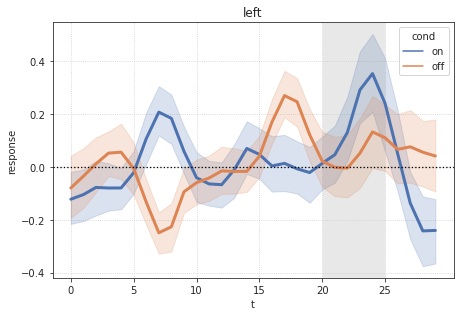

In [105]:
fig, ax = create_figure(1, 1, (6.5, 4.5), 'ticks', 'all', 'all')

ci=68

sns.lineplot(
    data=df,
    x='t',
    y='response',
    hue='cond',
    palette='deep',
    ci=ci,
    lw=3,
    ax=ax,
)
ax.axvspan(delay, delay + 5, facecolor='lightgrey', alpha=0.5, zorder=0)
ax.axhline(0, color='k', ls=':', lw=1.3)
ax.set(xticks=range(0, extent + delay, 5), title=hemis)
ax.grid(linestyle=':')
plt.show()

In [106]:
runs = [1, 3, 5, 7]

df = data.loc[
    (data.loc[:, 'sub'] == sub) &
    (data.loc[:, 'ses'].isin(sessions)) &
    (data.loc[:, 'run'].isin(runs)) &
    (data.loc[:, 'hemis'] == hemis) &
    (data.loc[:, 'region'] == region)
]
df.task.unique()

array(['rest'], dtype=object)

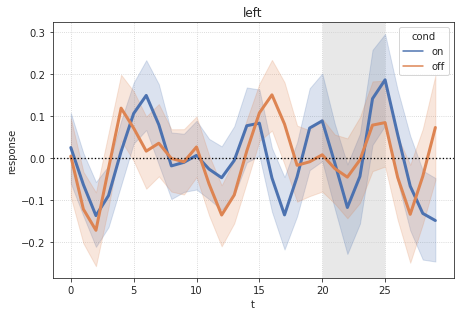

In [107]:
fig, ax = create_figure(1, 1, (6.5, 4.5), 'ticks', 'all', 'all')

ci=68

sns.lineplot(
    data=df,
    x='t',
    y='response',
    hue='cond',
    palette='deep',
    ci=ci,
    lw=3,
    ax=ax,
)
ax.axvspan(delay, delay + 5, facecolor='lightgrey', alpha=0.5, zorder=0)
ax.axhline(0, color='k', ls=':', lw=1.3)
ax.set(xticks=range(0, extent + delay, 5), title=hemis)
ax.grid(linestyle=':')
plt.show()

In [5]:
stim_on_global = [20 + i* 60 for i in range(9)]
stim_on_global

[20, 80, 140, 200, 260, 320, 380, 440, 500]

In [6]:
delay = 20
extent = 20
dlist = []
for sub in tqdm(mice.cfg.sub_ids):
    for ses in mice.cfg.ses_ids:
        for run in mice.cfg.run_ids:
            df = mice.bold_df
            df = df.loc[
                (df.subject == sub) &
                (df.session == ses) &
                (df.run == run)
            ]
            has_stim_file = False
            if df.stim.sum():
                has_stim_file = True

            for i in include:
                df_l = df.loc[df.region_id == f"0-315-{i}"]
                df_r = df.loc[df.region_id == f"1-315-{i + mice.cfg.n_cortex_regions // 2}"]
                stim = df_r.stim.values
                stim_on = [
                    idx + 1 for idx, (i, j)
                    in enumerate(zip(stim[:-1], stim[1:]))
                    if i - j == -1
                ]
                x_l = df_l.bold.values
                x_r = df_r.bold.values
                x_l = sp_stats.zscore(x_l)
                x_r = sp_stats.zscore(x_r)

                for on in stim_on_global:
                    intvl = range(on - delay, on + extent)
                    for hemis in ['left', 'right']:
                        x = x_l.copy() if hemis == 'left' else x_r.copy()
                        try:
                            x_main = x[intvl]
                        except IndexError:
                            continue

                        baseline = x_main[:delay].mean()
                        x_main -= baseline

                        data_dict = {
                            'has_stim_file': [has_stim_file] * len(intvl),
                            'cond': [df.task.unique().item()] * len(intvl),
                            'sub': [sub] * len(intvl),
                            'ses': [ses] * len(intvl),
                            'run': [run] * len(intvl),
                            'region': [i] * len(intvl),
                            't_on': [on] * len(intvl),
                            't': range(len(intvl)),
                            'hemis': [hemis] * len(intvl),
                            'response': x_main,
                        }
                        dlist.append(data_dict)
data = pd.DataFrame(merge_dicts(dlist))

  0%|          | 0/10 [00:00<?, ?it/s]

In [14]:
sessions = [1, 2, 3]
hemis = 'left'
region = 31

df = data.loc[
    #(data.loc[:, 'sub'] == sub) &
    #(data.loc[:, 'ses'].isin(sessions)) &
    # (data.loc[:, 'run'].isin(runs)) &
    (data.loc[:, 'hemis'] == hemis) &
    (data.loc[:, 'region'] == region)
]
df.cond.unique()

array(['rest', 'led'], dtype=object)

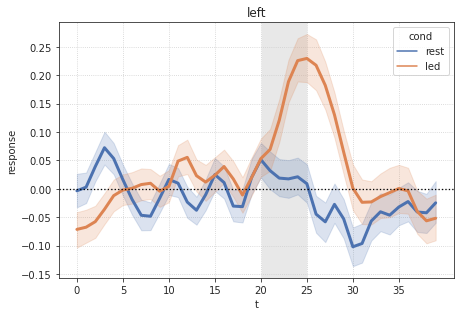

In [15]:
fig, ax = create_figure(1, 1, (6.5, 4.5), 'ticks', 'all', 'all')
ci = 68

sns.lineplot(
    data=df,
    x='t',
    y='response',
    hue='cond',
    palette='deep',
    ci=ci,
    lw=3,
    ax=ax,
)
ax.axvspan(delay, delay + 5, facecolor='lightgrey', alpha=0.5, zorder=0)
ax.axhline(0, color='k', ls=':', lw=1.3)
ax.set(xticks=range(0, extent + delay, 5), title=hemis)
ax.grid(linestyle=':')
plt.show()

In [138]:
# sub = 10
# sessions = [1, 2, 3]
# runs = [2, 4, 6]
hemis = 'left'
region = 31

df = data.loc[
    (data.loc[:, 'sub'].isin([e for e in mice.cfg.sub_ids if e not in [2, 3, 7, 9]])) &
    # (data.loc[:, 'ses'].isin(sessions)) &
    # (data.loc[:, 'run'].isin(runs)) &
    (data.loc[:, 'hemis'] == hemis) &
    (data.loc[:, 'region'] == region)
]
df.cond.unique()

array(['rest', 'led'], dtype=object)

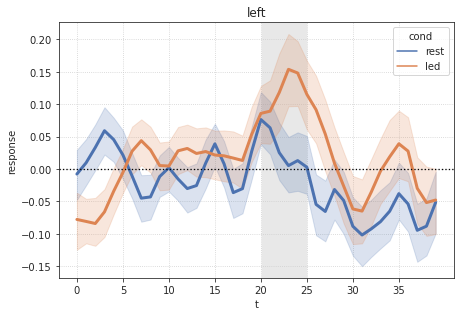

In [139]:
fig, ax = create_figure(1, 1, (6.5, 4.5), 'ticks', 'all', 'all')

ci=68

sns.lineplot(
    data=df,
    x='t',
    y='response',
    hue='cond',
    palette='deep',
    ci=ci,
    lw=3,
    ax=ax,
)
ax.axvspan(delay, delay + 5, facecolor='lightgrey', alpha=0.5, zorder=0)
ax.axhline(0, color='k', ls=':', lw=1.3)
ax.set(xticks=range(0, extent + delay, 5), title=hemis)
ax.grid(linestyle=':')
plt.show()

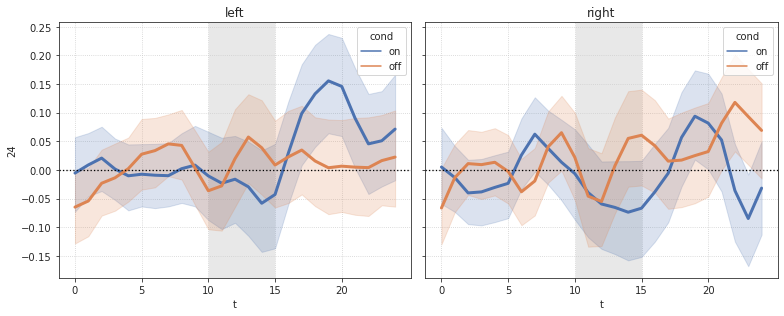

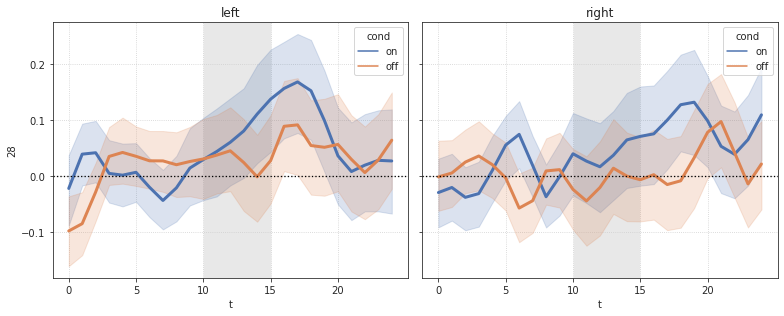

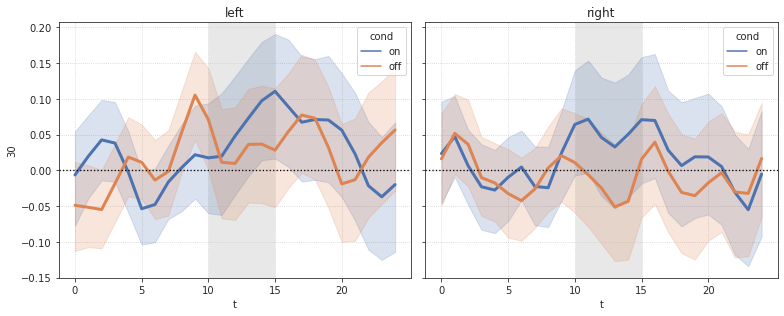

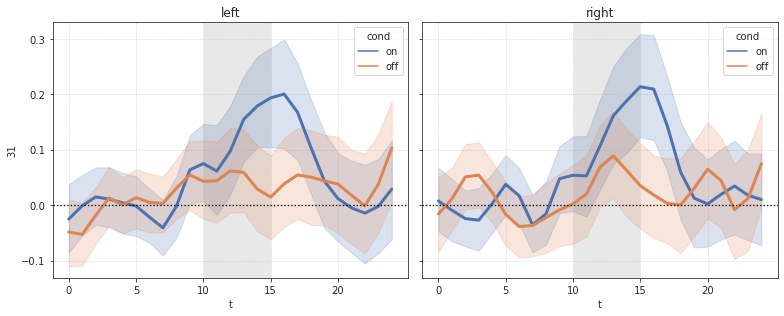

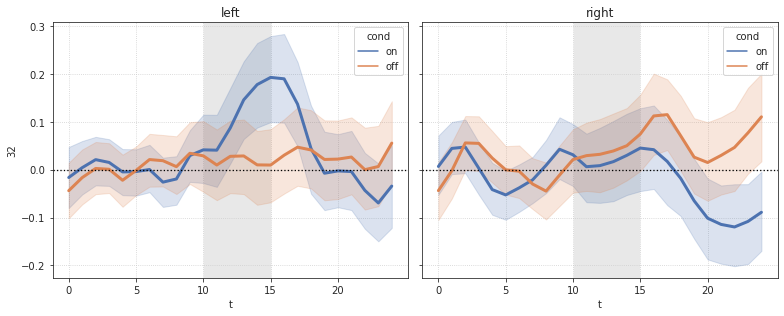

In [10]:
for region in include:

    fig, axes = create_figure(1, 2, (11, 4.5), 'ticks', 'all', 'all')
    for ax, lr in zip(axes, ['left', 'right']):
        sns.lineplot(
            data=data.loc[(data.hemis == lr) & (data.region == region)],
            x='t',
            y='response',
            hue='cond',
            palette='deep',
            lw=3,
            ax=ax,
        )
        ax.axvspan(delay, delay + 5, facecolor='lightgrey', alpha=0.5, zorder=0)
        ax.axhline(0, color='k', ls=':', lw=1.3)
        ax.set(xticks=range(0, extent + delay, 5), title=lr)
        if lr == 'left':
            ax.set_ylabel(region)
        ax.grid(linestyle=':')
    plt.show()

In [11]:
fig, axes = create_figure(len(include), 2, (12.5, 4.3 * len(include)), 'ticks', 'all', 'row')

for i, region in enumerate(include):
    for ax, lr in zip(axes[i], ['left', 'right']):
        sns.lineplot(
            data=data.loc[(data.hemis == lr) & (data.region == region)],
            x='t',
            y='response',
            hue='cond',
            palette='deep',
            ci=95,
            lw=3,
            ax=ax,
        )
        ax.axvspan(delay, delay + 5, facecolor='lightgrey', alpha=0.6, zorder=0)
        ax.axhline(0, color='k', ls=':', lw=1.3)
        ax.set(xticks=range(0, extent + delay, 5), title=lr)
        if lr == 'left':
            ylabel = f"ROI # {region}\n{include[region]}\n\n"
            ylabel += r"Normalized Sig. Intensity ± 95%"
            ax.set_ylabel(ylabel, fontsize=14)
        ax.grid(linestyle=':')
        
        if i == 0:
            ax.set_title(lr, y=1.05, fontsize=20)

fig.savefig(pjoin(tmp_dir, 'stim.pdf'), bbox_inches='tight')
plt.close()

In [12]:
nrows = 10
fig, axes = create_figure(nrows, 2, (12.5, 4.3 * nrows), 'ticks', 'all', 'row')

region = 31
ci = 68

for i, sub in enumerate(mice.cfg.sub_ids):
    for ax, lr in zip(axes[i], ['left', 'right']):
        sns.lineplot(
            data=data.loc[
                (data.hemis == lr) &
                (data.region == region) &
                (data.loc[:, 'sub'] == sub)
            ],
            x='t',
            y='response',
            hue='cond',
            palette='deep',
            ci=ci,
            lw=3,
            ax=ax,
        )
        ax.axvspan(delay, delay + 5, facecolor='lightgrey', alpha=0.6, zorder=0)
        ax.axhline(0, color='k', ls=':', lw=1.3)
        ax.set(xticks=range(0, extent + delay, 5), title=lr)
        if lr == 'left':
            ylabel = f"Mouse # {sub}.\nROI # {region}\n{include[region]}\n\n"
            ylabel += f"Normalized Sig. Intensity ± {ci}%"
            ax.set_ylabel(ylabel, fontsize=14)
        ax.grid(linestyle=':')
        
        if i == 0:
            ax.set_title(lr, y=1.05, fontsize=20)

fig.savefig(pjoin(tmp_dir, f"stim_mouse_ROI{region}.pdf"), bbox_inches='tight')
plt.close()

In [13]:
nrows = 10
fig, axes = create_figure(nrows, 2, (12.5, 4.3 * nrows), 'ticks', 'all', 'row')

region = 32
ci = 68

for i, sub in enumerate(mice.cfg.sub_ids):
    for ax, lr in zip(axes[i], ['left', 'right']):
        sns.lineplot(
            data=data.loc[
                (data.hemis == lr) &
                (data.region == region) &
                (data.loc[:, 'sub'] == sub)
            ],
            x='t',
            y='response',
            hue='cond',
            palette='deep',
            ci=95,
            lw=3,
            ax=ax,
        )
        ax.axvspan(delay, delay + 5, facecolor='lightgrey', alpha=0.6, zorder=0)
        ax.axhline(0, color='k', ls=':', lw=1.3)
        ax.set(xticks=range(0, extent + delay, 5), title=lr)
        if lr == 'left':
            ylabel = f"Mouse # {sub}.\nROI # {region}\n{include[region]}\n\n"
            ylabel += f"Normalized Sig. Intensity ± {ci}%"
            ax.set_ylabel(ylabel, fontsize=14)
        ax.grid(linestyle=':')
        
        if i == 0:
            ax.set_title(lr, y=1.05, fontsize=20)

fig.savefig(pjoin(tmp_dir, f"stim_mouse_ROI{region}.pdf"), bbox_inches='tight')
plt.close()

## GLM

In [335]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression, PoissonRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import matthews_corrcoef, accuracy_score, f1_score

def softmax(z, axis=0):
    e = np.exp(z)
    return e / e.sum(axis, keepdims=True)

In [336]:
mode = 'bold'
metric = 'pearson'
match_metric = 'cosine'

task = 'led'
mice = Mice(Config(256, normalization='global'), load_df=True, load_preproc=True)
mice.combine_dfs(task, full=True)

In [337]:
region_overlap = mice.parcel.get_region_overlap()

include = {}
for region, x in region_overlap.items():
    if 'VIS' in x and region <= mice.cfg.n_cortex_regions // 2:
        include[region] = x
include

  0%|          | 0/256 [00:00<?, ?it/s]

{
    98: {'VIS': 56.0, 'RSP': 37.0},
    100: {'VIS': 55.0, 'PTLp': 45.0},
    107: {'VIS': 91.0},
    108: {'RSP': 58.0, 'VIS': 42.0},
    111: {'VIS': 100.0},
    112: {'VIS': 66.0, 'AUD': 27.0},
    115: {'VIS': 100.0},
    117: {'VIS': 100.0},
    119: {'VIS': 100.0},
    120: {'VIS': 100.0},
    122: {'TEa': 55.0, 'VIS': 38.0},
    123: {'VIS': 100.0},
    124: {'RSP': 55.0, 'VIS': 45.0},
    125: {'VIS': 100.0},
    126: {'VIS': 100.0},
    127: {'VIS': 71.0, 'RSP': 29.0},
    128: {'VIS': 100.0}
}

In [412]:
delay = 0
extent = 20
pad = 0

xv_folds = 5
which_fold = 0

x_all = []
y_all = []
tst_all = []
trn_all = []

for sub in tqdm(mice.cfg.sub_ids):
    for ses in mice.cfg.ses_ids:
        for run in [2, 4, 6]:
            df = mice.bold_df
            df = df.loc[
                (df.subject == sub) &
                (df.session == ses) &
                (df.run == run)
            ]
            if not df.stim.sum():
                continue

            bold = {}
            for region in df.region_id.unique():
                if '315' not in region:
                    continue
                _df = df.loc[df.region_id == region]
                bold[region] = _df.bold.values
            stim_times = _df.stim.values
            stim_on = [
                idx + 1 for
                idx, (i, j) in enumerate(zip(stim_times[:-1], stim_times[1:]))
                if i - j == -1
            ]

            x_on = []
            x_off = []
            for on in stim_on:
                for cond in ['on', 'off']:
                    if cond == 'on':
                        intvl = range(on - delay, on + extent)
                    else:
                        intvl = range(on + 60 - pad - (delay + extent), on + 60 - pad)

                    if intvl.stop >= len(stim_times):
                        continue

                    x = []
                    for i in include:
                        resp = sp_stats.zscore(bold[f"0-315-{i}"])
                        resp = resp[intvl]
                        resp = np.expand_dims(resp, axis=0)
                        x.append(resp)
                    x = np.concatenate(x)

                    if cond == 'on':
                        x_on.append(np.expand_dims(x, axis=0))
                    else:
                        x_off.append(np.expand_dims(x, axis=0))
            x_on = np.concatenate(x_on)
            x_off = np.concatenate(x_off)
            x = np.concatenate([x_on, x_off])
            x = x.reshape(len(x), -1)
            x_all.append(x)

            on_ids = np.array(range(len(x_on)))
            off_ids = np.array(range(len(x_on), len(x_on) + len(x_off)))

            y = np.zeros(len(x))
            y[on_ids] = 1
            y_all.append(y)

            on_tst, on_trn = train_test_split(len(x_on), xv_folds=xv_folds, which_fold=which_fold)
            off_tst, off_trn = train_test_split(len(x_off), xv_folds=xv_folds, which_fold=which_fold)
            on_tst, on_trn = on_ids[on_tst], on_ids[on_trn]
            off_tst, off_trn = off_ids[off_tst], off_ids[off_trn]
            tst = np.concatenate([on_tst, off_tst])
            trn = np.concatenate([on_trn, off_trn])
            assert not set(tst).intersection(set(trn))

            tst_all.append(tst)
            trn_all.append(trn)

  0%|          | 0/10 [00:00<?, ?it/s]

In [413]:
x_tst, x_trn, y_tst, y_trn = [], [], [], []
for _x, _y, _tst, _trn in zip(x_all, y_all, tst_all, trn_all):
    x_tst.append(_x[_tst])
    x_trn.append(_x[_trn])
    y_tst.append(_y[_tst])
    y_trn.append(_y[_trn])
x_tst = np.concatenate(x_tst)
x_trn = np.concatenate(x_trn)
y_tst = np.concatenate(y_tst)
y_trn = np.concatenate(y_trn)

x_tst.shape,  y_tst.shape, x_trn.shape, y_trn.shape

((316, 340), (316,), (1027, 340), (1027,))

In [414]:
C = 1

lr = LogisticRegression(
    penalty='l2',
    C=C,
    class_weight='balanced',
    solver='lbfgs',
    max_iter=int(1e7),
    tol=1e-6,
    random_state=42,
).fit(x_trn, y_trn)

y_pred = lr.predict(x_tst)
matthews_corrcoef(y_tst, y_pred)

0.006330255116004461

In [415]:
kernel = lr.coef_.reshape(-1, (extent + delay)).copy()
kernel.shape

(17, 20)

[<matplotlib.lines.Line2D object at 0x7e3116d50040>]

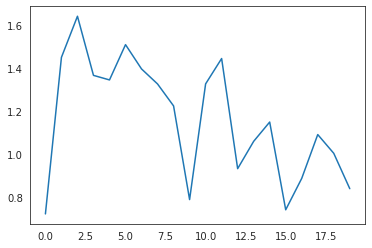

In [416]:
plt.plot(np.linalg.norm(kernel, axis=0))

[<matplotlib.lines.Line2D object at 0x7e3116da5d00>]

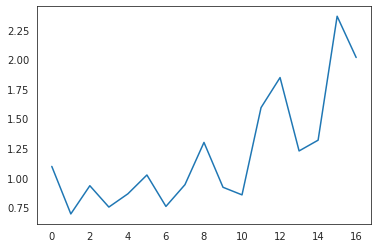

In [417]:
plt.plot(np.linalg.norm(kernel, axis=1))

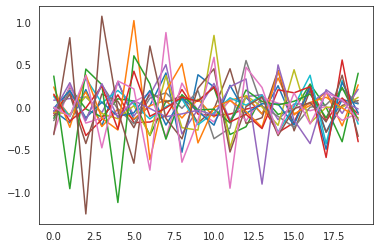

In [418]:
plt.plot(kernel.T);

In [419]:
pr = PoissonRegressor(
    alpha=1.0,
).fit(x_trn, y_trn)

y_pred = lr.predict(x_tst)
matthews_corrcoef(y_tst, y_pred)

0.006330255116004461

In [420]:
kernel = pr.coef_.reshape(-1, (extent + delay)).copy()
kernel.shape

(17, 20)

[<matplotlib.lines.Line2D object at 0x7e3116e0a670>]

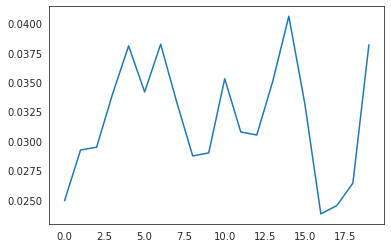

In [421]:
plt.plot(np.linalg.norm(kernel, axis=0))

[<matplotlib.lines.Line2D object at 0x7e3116e9aaf0>]

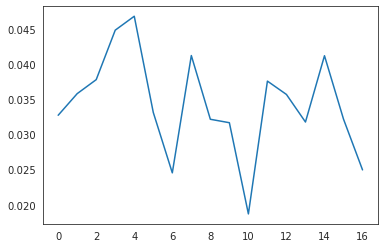

In [422]:
plt.plot(np.linalg.norm(kernel, axis=1))